In [32]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, votable
from astropy.table import Table, vstack, hstack
import os, sys
from astropy.io import fits

## 1. MMDD crossmatch

### convert into .npy (3 lines lacking icrsra information excluded)

In [711]:
MMDD = Table.read('MWDD-export.csv')
MMDD = MMDD[MMDD['icrsra'].mask==False]
(MMDD['icrsra'].mask==True).sum()
print(len(MMDD))
MMDD_ra = np.empty(len(MMDD))
MMDD_dec = np.empty(len(MMDD))
for i in range(len(MMDD)):
    MMDD_ra[i] = 15 * (int(MMDD['icrsra'][i][0:2]) +int(MMDD['icrsra'][i][3:5])/60 + float(MMDD['icrsra'][i][6:])/3600)
    if MMDD['icrsdec'][i][0] == '-':
        MMDD_dec[i] = -1* (int(MMDD['icrsdec'][i][1:3]) + int(MMDD['icrsdec'][i][4:6])/60 +  float(MMDD['icrsdec'][i][7:])/3600)
    else:   
        MMDD_dec[i] = (int(MMDD['icrsdec'][i][0:2]) + int(MMDD['icrsdec'][i][3:5])/60 +  float(MMDD['icrsdec'][i][6:])/3600)
MMDD['ra'] = MMDD_ra
MMDD['dec'] = MMDD_dec
np.save('MMDD.npy',np.array([{'MMDD':MMDD}]))

36961


In [927]:
MMDD[15219]

<Row index=15219 masked=True>
          wdid                      name              icrsra     icrsdec   spectype   teff   Dteff    logg   Dlogg    mass   Dmass  ismag    su      sg      sr      si      sz    nbUV nbOpt       ra           dec     
         str30                     str25              str11       str12     str72   float64 float64 float64 float64 float64 float64  str3 float64 float64 float64 float64 float64 int64 int64    float64       float64   
------------------------ ------------------------- ----------- ----------- -------- ------- ------- ------- ------- ------- ------- ----- ------- ------- ------- ------- ------- ----- ----- ------------- -------------
SDSS J031555.99+174548.6 SDSS J031555.99+174548.67 03 15 55.99 17 45 48.66       DA  8781.0   116.0    5.66    0.57    0.13   0.037    --   21.73   20.36   20.34   20.38   20.53     0     1 48.9832916667 17.7635166667

### load npy

In [958]:
MMDD = np.load('MMDD.npy')[0]['MMDD']
MMDD.sort('dec')

In [982]:
WD_sdss = np.load('WD_table_sdss.npy')[0]['table']
Gaia_xmatch_sdss = np.load('WD_table_sdss.npy')[0]['sdss']
WD_sdss['index'] = np.arange(len(WD_sdss))
len(WD_sdss)

18495

### cross-matching

In [983]:
WD_sdss['MMDD_index'] = np.zeros(len(WD_sdss),dtype=int)
WD_sdss['MMDD_d'] = np.zeros(len(WD_sdss),dtype=float)

In [984]:
for i in range(len(WD_sdss)):
    d = np.sqrt(((WD_sdss[i]['ra'] - MMDD['ra']) * np.cos(WD_sdss[i]['dec']/180*np.pi) - WD_sdss[i]['pmra']*15/3600000 )**2 + 
            (WD_sdss[i]['dec'] - WD_sdss[i]['pmdec']*15/3600000- MMDD['dec'] )**2 )
    WD_sdss['MMDD_index'][i] = np.where(d == d.min())[0][0]
    WD_sdss['MMDD_d'][i] = d.min() * 3600

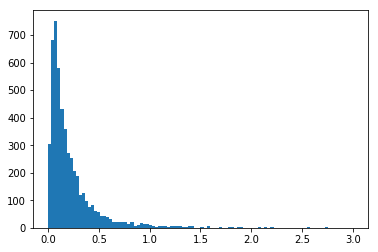

In [985]:
plt.hist(WD_sdss['MMDD_d'],100,(0,3))
plt.show()

In [986]:
WD_sdss['MMDD_r'] = MMDD['sr'][WD_sdss['MMDD_index']]
WD_sdss['MMDD_u'] = MMDD['su'][WD_sdss['MMDD_index']]
WD_sdss['MMDD_g'] = MMDD['sg'][WD_sdss['MMDD_index']]
WD_sdss['MMDD_i'] = MMDD['si'][WD_sdss['MMDD_index']]
WD_sdss['nbOpt'] = MMDD['nbOpt'][WD_sdss['MMDD_index']]
WD_sdss['ismag'] = MMDD['ismag'][WD_sdss['MMDD_index']]
WD_sdss['spectype'] = MMDD['spectype'][WD_sdss['MMDD_index']]
WD_sdss['m_M'] = 5 * np.log10(1/WD_sdss['parallax']*1000) - 5
WD_sdss['name'] = MMDD['name'][WD_sdss['MMDD_index']]
np.save('WD_table_sdss.npy',np.array([{'table':WD_sdss,'sdss':Gaia_xmatch_sdss}])) ## transport this to local computer

In [987]:
small_d = (WD_sdss['MMDD_d']<0.7) * (WD_sdss['nbOpt']>0)
(small_d).sum()

4624

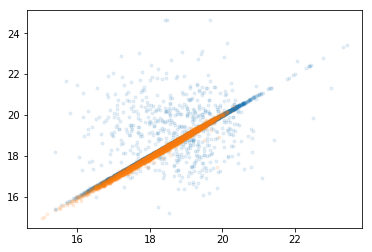

In [988]:
plt.plot(WD_sdss['MMDD_u'][small_d],Gaia_xmatch_sdss['u_mag'][small_d],'.',alpha=0.1)
plt.plot(WD_sdss['MMDD_r'][small_d],WD_sdss['phot_g_mean_mag'][small_d],'.',alpha=0.1)
plt.show()

## 2. spectral files: create spec.npy

to continue from the cell on server,
1. then download the csv file and upload it to Casjob (finished)
2. match the obj_id with SEGUE list and get PLATE, MJD, FIBERID (finished)
3. download from Casjob in .csv format (finished)
4. change the null into empty (to be done below)
5. upload the non-null PLATE, MJD, FIBERID to SEGUE spec query (limit of 1000 for each time) https://dr14.sdss.org/optical/spectrum/search

### download spectra

In [991]:
table = Table.read('WD_sdss_spectral_index_13000_all.csv',format='csv')
table.remove_rows(np.where(table['index1'][1:]-table['index1'][:-1] == 0))
len(table), len(WD_sdss)

(18495, 18495)

In [995]:
with_spec = table['MJD']!='null'
print(with_spec.sum())
table[with_spec][0]

4786


<Row index=0>
       obj_id        MJD  PLATE FIBERID index1
       str19         str5  str4   str4  int64 
------------------- ----- ----- ------- ------
1237655691943936384 52409   924     163     16

### upload these mjd / plate / fiber to SDSS SAS

In [1008]:
for i in range(4000,with_spec.sum()):
    print(table[with_spec]['PLATE'][i]+','+table[with_spec]['MJD'][i]+','+table[with_spec]['FIBERID'][i])

2821,54393,218
3859,55246,98
2672,54085,543
4992,55723,974
974,52427,241
2608,54474,396
5973,56067,432
3928,55331,569
3934,55336,988
1575,53493,393
1056,52764,405
4410,56187,812
2697,54389,602
4456,55537,12
1321,52764,208
1321,52764,151
2184,53534,611
2055,53729,496
2075,53730,161
2075,53730,149
2075,53730,275
6316,56483,713
6313,56460,538
2438,54056,368
2437,53848,217
581,52356,106
3406,54970,405
1397,53119,405
978,52441,4
5003,55715,790
7039,56572,886
6803,56402,120
6803,56402,862
5200,56091,804
6159,56214,101
2622,54095,38
6006,56105,278
2118,53820,318
6006,56105,274
6006,56105,348
8390,57485,621
1057,52522,517
2486,53876,133
6635,56370,334
2462,54561,404
4611,55603,883
2089,53498,318
6716,56401,928
2187,54270,229
620,52375,520
6623,56367,571
6061,56076,311
1290,52734,312
1290,52734,270
6061,56076,860
2615,54483,446
580,52368,274
366,52017,353
366,52017,342
1375,53084,138
3294,54918,40
772,52375,542
772,52375,526
4726,55712,64
3689,55180,826
4714,56041,236
3859,55246,228
483,51924,3

2399,53764,244
4425,55864,91
4955,55750,572
1058,52520,347
4064,55366,510
1571,53174,496
4187,55693,828
354,51792,233
976,52413,198
6064,56097,964
2247,54169,45
2256,53859,97
6064,56097,922
2256,53859,70
3987,55590,974
6673,56419,608
1672,53460,557
814,52443,615
3428,54979,618
4984,55827,40
956,52401,406
452,51911,351
7445,56720,597
754,52232,544
5328,55982,790
2584,54153,597
2262,54623,569
2262,54623,548
2262,54623,618
556,51991,571
8223,57429,185
8223,57429,74
1873,54437,469
5152,56010,836
473,51929,74
3823,55534,662
474,52000,367
475,51965,315
1984,53433,165
6314,56191,318
6491,56337,828
2095,53474,567
6747,56388,622
6746,56386,984
5188,55803,358
4955,55750,854
367,51997,512
995,52731,247
3187,54821,238
6038,56090,135
624,52377,332
813,52354,19
6679,56401,600
7254,56625,541
625,52145,299
2584,54153,632
7426,56771,557
1382,53115,342
976,52413,597
976,52413,623
8847,57429,412
4189,55679,974
4189,55679,968
8222,57431,148
689,52262,261
689,52262,264
817,52381,152
5191,56065,216
5191,560

1. save a bash file with header #!bash and add wget to each line.
2. execute the bash file to download spectral files from SDSS. (to the dslogin01 server)
3. move back to dslogin01 server to work

In [867]:
from scipy.interpolate import interp1d

dir_WD_spectra = 'WD_spectra_all/'
name_list = os.listdir(dir_WD_spectra)
def open_one_spec_by_name_list(i,med_size=3,pl=True):
    name = name_list[i]
    hdul = fits.open(dir_WD_spectra+name)
    lam = 10**hdul[1].data['loglam']
    flux = hdul[1].data['flux']
    flux_med = medfilt(flux,med_size)
    func = interp1d(lam, flux_med, kind='linear', bounds_error=False, fill_value=(flux[0],flux[-1]), assume_sorted=True)
    lam_grid = lam_standard
    if pl==True:
        plt.figure(figsize=(18,6))
        plt.plot(lam_grid,func(lam_grid))
        plt.axvline(6563)
        plt.axvline(3646)
        plt.show()
    return lam_grid, func(lam_grid)

def open_one_spec(i,med_size=3,pl=True):
    name = 'spec-'+'%04i' % (int(table['PLATE'][i])) + '-' + '%5i' % (int(table['MJD'][i])) + '-' +\
                '%04i' % (int(table['FIBERID'][i]))
    
    hdul = fits.open(dir_WD_spectra+name)
    lam = 10**hdul[1].data['loglam']
    flux = hdul[1].data['flux']
    flux_med = medfilt(flux,med_size)
    func = interp1d(lam, flux_med, kind='linear', bounds_error=False, fill_value=(flux[0],flux[-1]), assume_sorted=True)
    lam_grid = lam_standard
    if pl==True:
        plt.figure(figsize=(18,6))
        plt.plot(lam_grid,func(lam_grid))
        plt.axvline(6563)
        plt.axvline(3646)
        plt.show()
    return lam_grid, func(lam_grid)

### convert fits to npy

In [574]:
spec = np.empty((len(name_list),3803))
for i in range(len(name_list)):
    a, spec[i,:] = open_one_spec(i,5,pl=False)
spec_norm = spec / spec.mean(axis=1).reshape(-1,1)
spec_norm[np.isnan(spec_norm)] = 1
np.save('WD_spec_unnorm.npy',np.array([{'spec':spec,'lam_standard':lam_standard,'name_list':name_list}]))

/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


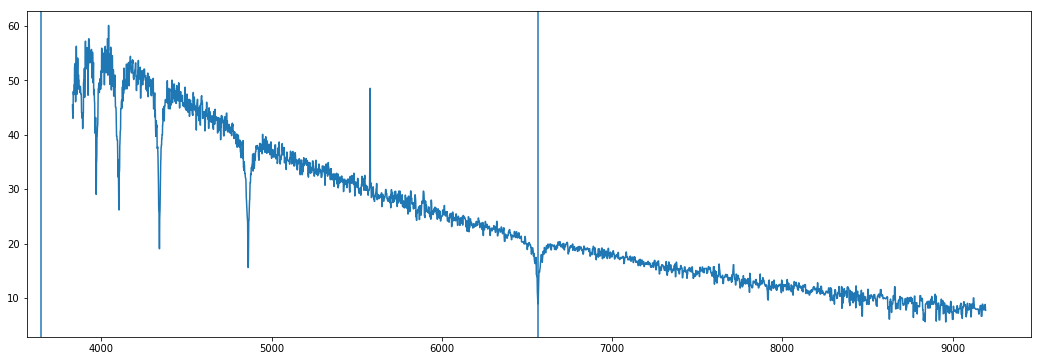

In [260]:
i = 0
_,_ = open_one_spec(i,3)

### load npy spec

In [869]:
data = np.load('WD_spec_unnorm.npy')[0]
spec = data['spec']
lam_standard = data['lam_standard']
name_list = data['name_list']

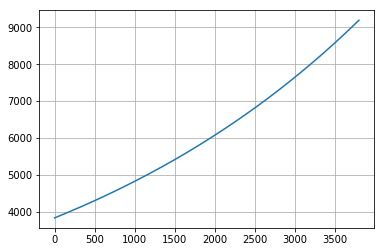

In [539]:
plt.plot(lam_standard)
plt.grid()
plt.show()
g_band = np.arange(0,1500)
r_band = np.arange(1500,2500)
i_band = np.arange(2500,3250)
z_band = np.arange(690,3800)

In [870]:
g = -2.5*np.log10(spec[:,g_band].sum(axis=1))
r = -2.5*np.log10(spec[:,r_band].sum(axis=1))
i_mag = -2.5*np.log10(spec[:,i_band].sum(axis=1))
z = -2.5*np.log10(spec[:,z_band].sum(axis=1))
bp = -2.5*np.log10(spec[:,0:2300].sum(axis=1))
rp = -2.5*np.log10(spec[:,2300:].sum(axis=1))
G = -2.5*np.log10(spec[:,:].sum(axis=1))


/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel pac

/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


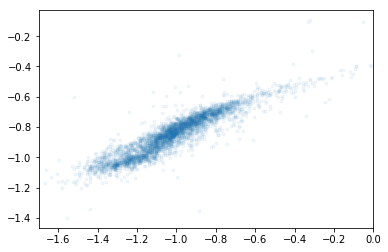

In [577]:
plt.plot(g - r, r - i,'.',alpha=0.05)
plt.xlim(-1.7,0)
plt.show()

## 3. crossmatch Gaia and spec.npy

### remove duplicate rows

In [989]:
table = Table.read('WD_sdss_spectral_index_13000_all.csv',format='csv')
table.remove_rows(np.where(table['index1'][1:]-table['index1'][:-1] == 0))
len(table), len(WD_sdss)

(18495, 18495)

In [990]:
table[0]

<Row index=0>
       obj_id        MJD  PLATE FIBERID index1
       str19         str5  str4   str4  int64 
------------------- ----- ----- ------- ------
1237655691943936384 52409   924     163     16

In [954]:
WD_sdss['my_spec_index'] = np.empty((len(table)),dtype=int)
plate = np.empty(len(name_list),dtype=int)
mjd = np.empty(len(name_list),dtype=int)
fib = np.empty(len(name_list),dtype=int)

for i in range(len(name_list)):
    plate[i] = int(name_list[i][5:9])
    mjd[i] = int(name_list[i][10:15])
    fib[i] = int(name_list[i][16:20])
    
for i in range(len(table)):
    if table['FIBERID'][i]=='null':
        WD_sdss['my_spec_index'][i] = -1
    else:
        WD_sdss['my_spec_index'][i] = np.where((plate == int(table[i]['PLATE'])) * (mjd == int(table[i]['MJD'])) * \
                (fib == int(table[i]['FIBERID'])))[0]

In [872]:
spec2Gaia = np.arange(len(WD_sdss))[table['FIBERID']!='null']
Gaia2spec = WD_sdss['my_spec_index'][WD_sdss['my_spec_index']>-1]
Gaia_with_spec = WD_sdss['my_spec_index']>-1
np.save('sdss_with_spec.npy',np.array([{'spec2Gaia':spec2Gaia,'g':g[Gaia2spec],'r':r[Gaia2spec],\
                                        'i':i_mag[Gaia2spec],'z':z[Gaia2spec],'bp':bp[Gaia2spec],'rp':rp[Gaia2spec],\
                                        'G':G[Gaia2spec],'Gaia2spec':Gaia2spec,'Gaia_with_spec':Gaia_with_spec}]))

In [875]:
WD_with_spec = WD_sdss[Gaia_with_spec]
WD_with_spec['spec_g'] = g[Gaia2spec]
WD_with_spec['spec_r'] = r[Gaia2spec]
WD_with_spec['spec_i'] = i_mag[Gaia2spec]
WD_with_spec['spec_z'] = z[Gaia2spec]
WD_with_spec['spec_G'] = G[Gaia2spec]
WD_with_spec['spec_bp'] = bp[Gaia2spec]
WD_with_spec['spec_rp'] = rp[Gaia2spec]

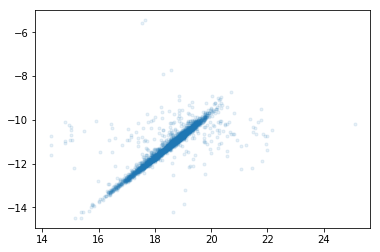

In [877]:
plt.plot(WD_with_spec['MMDD_g'],WD_with_spec['spec_g'],'.',alpha=0.1)
plt.plot(WD_with_spec['MMDD_g'],WD_with_spec['phot_g_mean_mag'],'.',alpha=0.1)
plt.show()

## split in WD sequence

In [910]:
def plot_HR(table,func,func_select,pl_only_all=False):
    ismag = table['ismag'].mask==False
    DA = table['spectype'] == 'DA'
    DB = table['spectype'] == 'DB'
    DQ = table['spectype'] == 'DQ'
    DC = table['spectype'] == 'DC'
    others = ~DA*~DB*~DC*~DQ
    
    plt.figure(figsize=(12,6))
    x = (table['bp_rp'])
    #x = (table['MMDD_u']) - table['MMDD_r']
    y = (table['phot_g_mean_mag']-table['m_M'])
    #y = (table['MMDD_u']-table['m_M'])
    if pl_only_all == True:
        plt.plot(x,y,'.',alpha=0.1)
        plt.plot([xmin, xmin, xmax, xmax, xmin],\
                     [func(xmin,offset,slope)-width,func(xmin,offset,slope)+width,func(xmax,offset,slope)+width,func(xmax,offset,slope)-width,\
                      func(xmin,offset,slope)-width ])
        plt.ylim(16,8)
        plt.show()
        return True
    else:
        plt.plot(x,y,'.',alpha=0.1)
        plt.plot(x[DA],y[DA],'.',label='DA',alpha=0.5)
        #plt.plot(x[DB],y[DB],'.',label='DB')
        plt.plot(x[DQ],y[DQ],'.',label='DQ')
        #plt.plot(x[DC],y[DC],'.',label='DC')
        #plt.plot(x[others],y[others],'.',label='other')
        plt.plot(x[ismag],y[ismag],'.',label='magnetic')
        plt.legend()
        plt.plot([xmin, xmin, xmax, xmax, xmin],\
                     [func(xmin,offset,slope)-width,func(xmin,offset,slope)+width,func(xmax,offset,slope)+width,func(xmax,offset,slope)-width,\
                      func(xmin,offset,slope)-width ])
        selected = func_select(x,y,offset,slope,width,xmin,xmax)
        #plt.plot(x[selected],y[selected],'.',label='selected')
        plt.ylim(16,8)
        plt.show()
        return selected

In [897]:
xmin = -0.40
xmax = 0.10
offset = 13.1
width = 0.15
slope = 1
func = lambda x, offset, slope: offset+x*slope
func_select = lambda x, y, offset, slope, width, xmin, xmax: (np.abs(offset+x*slope-y)<width) * (x>xmin) * (x<xmax)

### MMDD

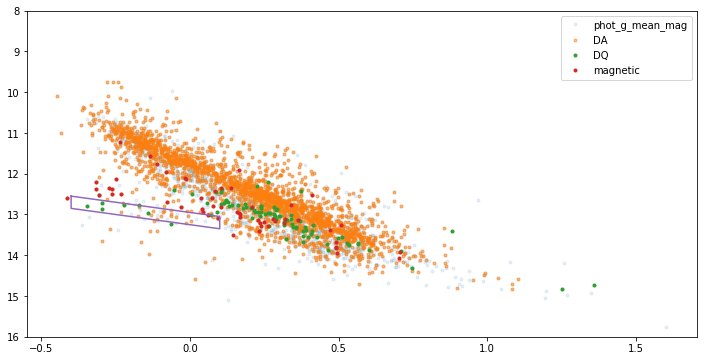

In [917]:
selected_low_MMDD = plot_HR(WD_sdss[small_d],func,func_select)

In [923]:
for i in range(selected_low_MMDD.sum()):
    print(WD_sdss[small_d][selected_low_MMDD]['name'][i])

KUV 08084+4221
SDSS J110752.87-160705.4
SDSS J090707.34+253313.46
SDSS_J004705.83-004819.6
SDSS J151314.08+545420.5
SDSS J113359.94+633113.2
SDSS J225828.49+280829.04
SDSS J091440.38+111336.2
SDSS J141309.30+191832.0
SDSS J093054.57-012642.94
SDSS J120331.90+645101.3
SDSS J135107.00+074345.66
SDSS J134946.37+125613.52
SDSS_J113156.19+534654.1
SDSS J080042.48+065542.1
SDSS_J110217.13+541954.0
SDSS_J084717.71+322209.4
SDSS_J165407.32+195623.8
SDSS J141251.04+140104.01
SDSS J100932.73+524638.2
SDSS J110058.04+175807.0
SDSS J144854.80+051903.54
SDSS J100759.80+162349.6
SDSS J151130.20+422023.0
SDSS J095837.00+585303.01
SDSS J150318.12+075718.02
SDSS J082626.37+504222.03
SDSS J103935.51+295413.6
SDSS J105937.60+365346.99
SDSS_J155857.28+480047.4
SDSS_J160510.58+502049.3
SDSS J122849.86+160656.7
SDSS J162236.13+300454.48
SDSS J021205.31+064420.5
SDSS J034630.98+094827.5
SDSS J163540.12+470427.42
SDSS J005047.60-002316.9


### my spec table

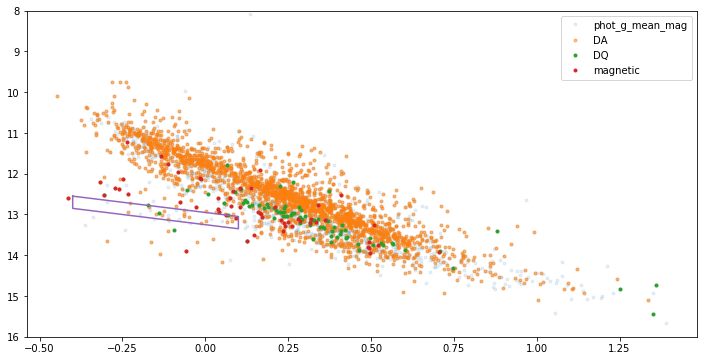

In [912]:
selected_low = plot_HR(WD_with_spec,func,func_select)

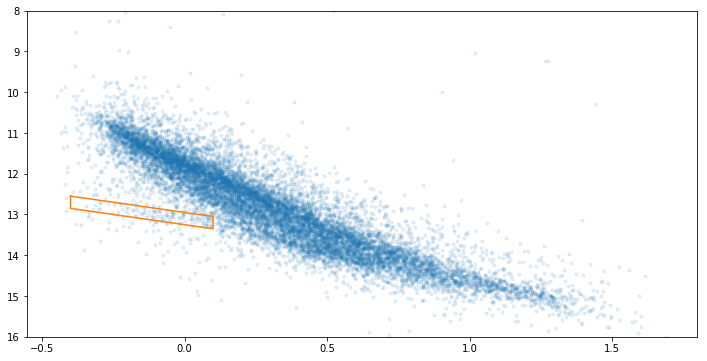

True

In [911]:
plot_HR(WD_sdss,func,func_select,True)

In [924]:
for i in range(selected_low.sum()):
    print(WD_with_spec[selected_low]['name'][i])

SDSS J110752.87-160705.4
SDSS_J004705.83-004819.6
SDSS J114250.22+001434.98
SDSS J151314.08+545420.5
SDSS J113359.94+633113.2
SDSS J114006.35+182402.3
SDSS J091440.38+111336.2
SDSS J141309.30+191832.0
SDSS J120331.90+645101.3
SDSS J072724.66+403622.0
SDSS_J113156.19+534654.1
SDSS J080042.48+065542.1
SDSS_J110217.13+541954.0
SDSS J210452.10+762260.0
SDSS_J084717.71+322209.4
SDSS_J165407.32+195623.8
SDSS J100932.73+524638.2
SDSS J110058.04+175807.0
SDSS J100759.80+162349.6
SDSS J151130.20+422023.0
SDSS J103935.51+295413.6
SDSS J105937.60+365346.99
SDSS_J155857.28+480047.4
SDSS_J160510.58+502049.3
SDSS J122849.86+160656.7
SDSS J021205.31+064420.5
SDSS J034630.98+094827.5
SDSS J031555.99+174548.67
SDSS J005047.60-002316.9


29


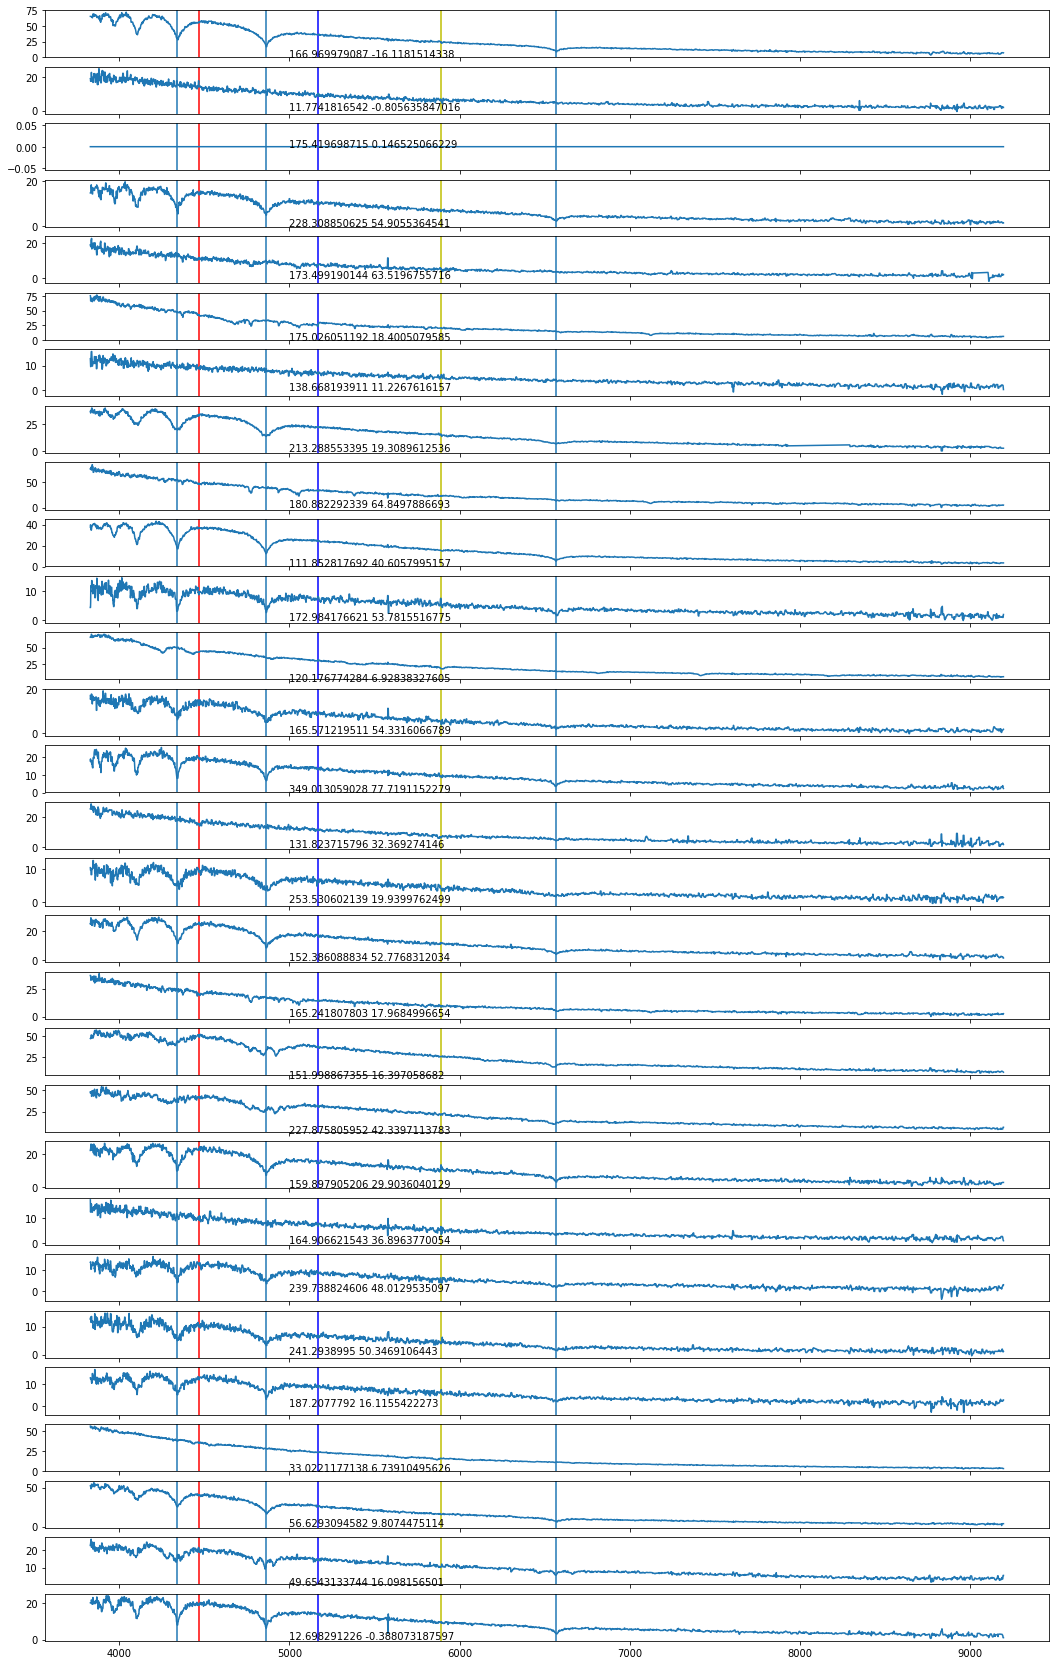

In [920]:
my_spec_index = WD_with_spec[selected_low]['my_spec_index']
n = len(my_spec_index)
print(n)
fig, axes = plt.subplots(n,1, sharex='col',figsize=(18,30))
for i in range(n):
    axes[i].axvline(6563)
    axes[i].axvline(4861.3615)
    axes[i].axvline(4340.462)
    axes[i].axvline(5893,c='y')
    axes[i].axvline(4471,c='r')
    axes[i].axvline(5170.462,c='b')
    axes[i].plot(lam_standard,spec[my_spec_index[i],:])
    axes[i].text(5000,0,str(WD_with_spec[selected_low]['ra'][i])+' '+str(WD_with_spec[selected_low]['dec'][i]))
plt.show()

# PCA

In [413]:
from sklearn.decomposition import PCA
def pca_analysis(vectors, x, n_component = 5,pl=[1,1,1,1,1]):
    pca = PCA(n_components = n_component,whiten=True)
    pca.fit(vectors)
    if pl[0]==True:
        plt.plot(pca.explained_variance_ratio_,'.-')
        plt.show()
        print(pca.explained_variance_ratio_)
    if pl[1]==True:
        plt.plot(x, pca.inverse_transform(np.zeros(n_component)))  
        plt.show()
    if pl[2]==True:
        plt.figure(figsize=(12,24))
        for i in range(n_component):
            plt.subplot(10,2,i+1)
            vector = np.zeros(n_component)
            vector[i] = 1
            plt.plot(x, pca.inverse_transform(vector))  
        plt.show()
    components = pca.transform(vectors)
    if pl[3]==True:
        plt.figure(figsize=(18,18))
        for j in range(n_component):
            for i in range(n_component):
                plt.subplot(n_component,n_component,i+1+n_component*j)
                plt.plot(components[:,i],components[:,j],'.',alpha=0.05)
                #plt.plot(components[selected_a,i],components[selected_a,j],'.',alpha=0.05)
                #plt.plot(components[selected_b,i],components[selected_b,j],'.',alpha=0.05)
                plt.xlim(-4,4)
                plt.ylim(-4,4)
        plt.show()
    if pl[4]==True:
        plt.figure(figsize=(18,24))
        for i in range(80):
            plt.subplot(16,5,i+1)
            plt.plot(x,vectors[i,:])
            plt.plot(x,vectors[i,:] - pca.inverse_transform(components[i]))
        plt.show()
    return pca, components

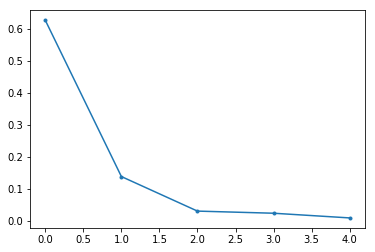

[ 0.62737575  0.13871403  0.03069538  0.02404596  0.00939774]


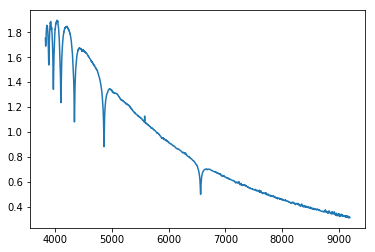

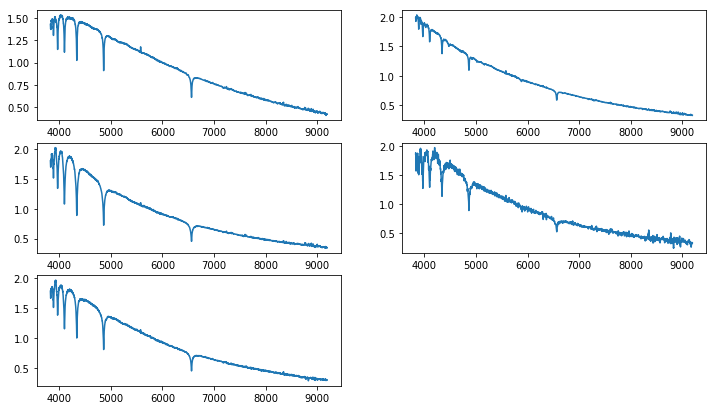

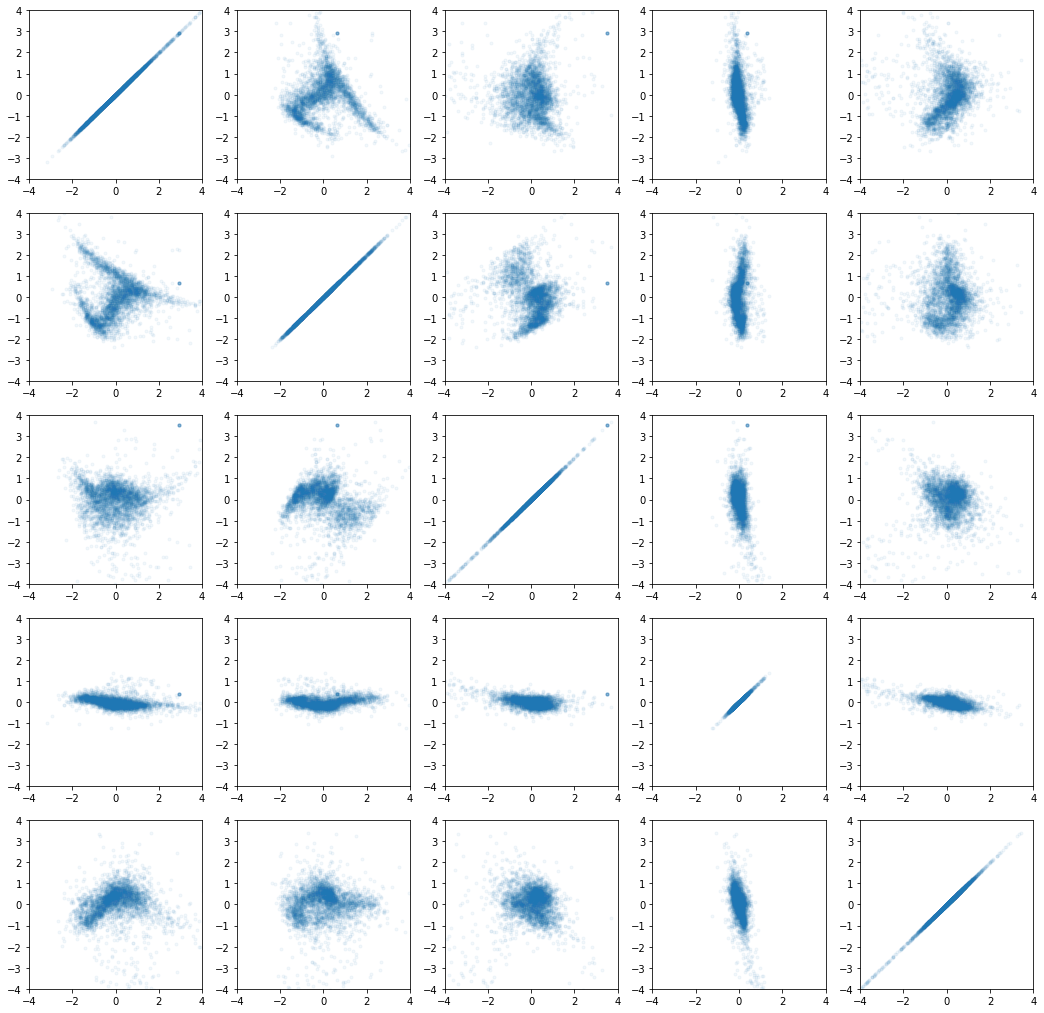

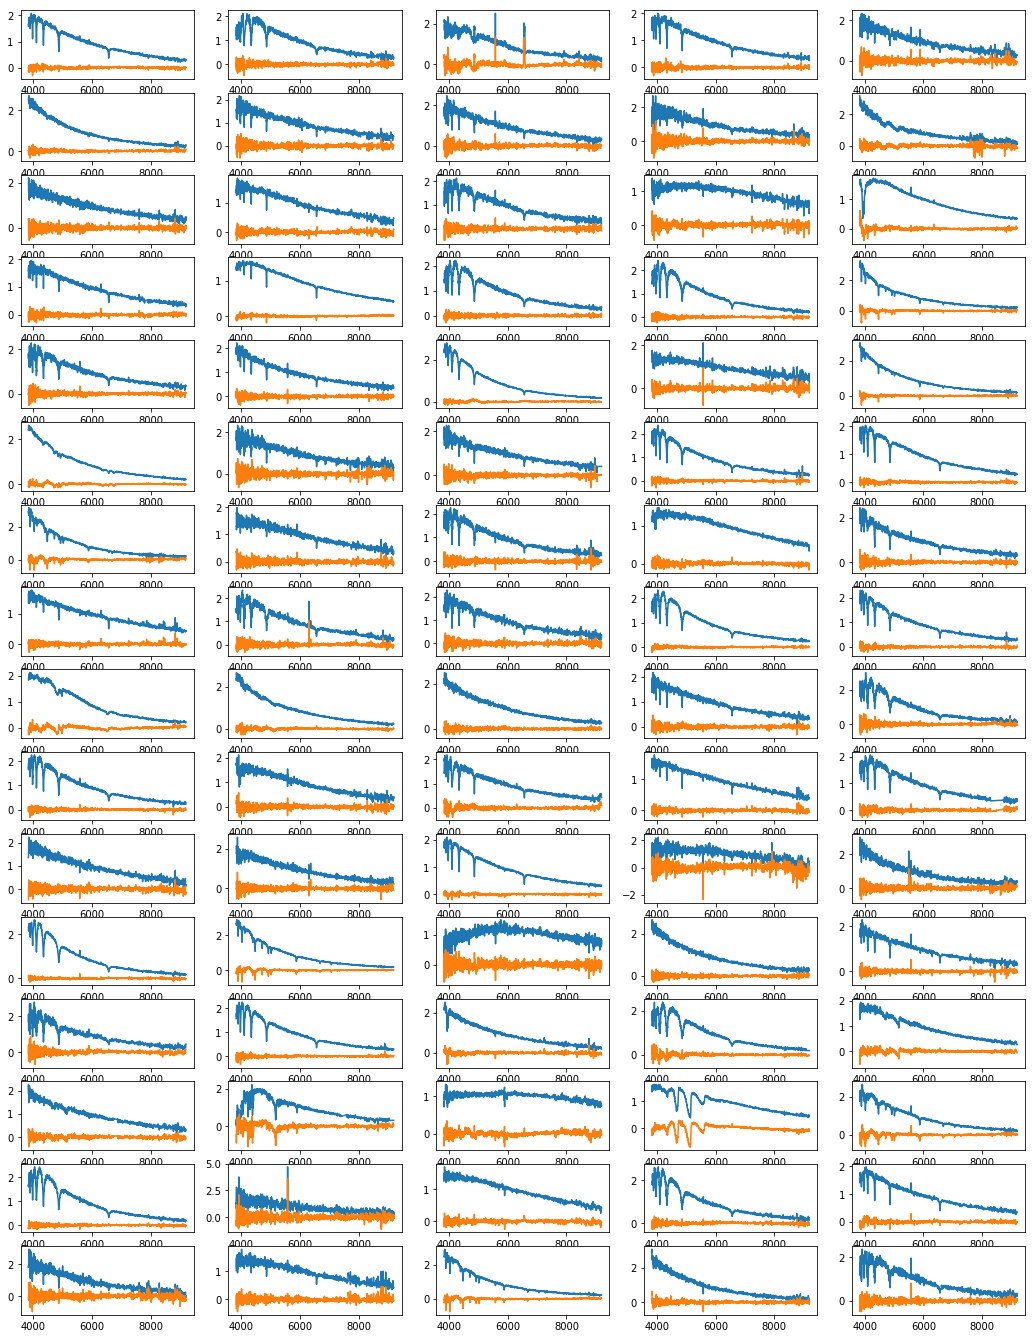

In [445]:
pca_all,_ = pca_analysis(spec, lam_standard, 5)

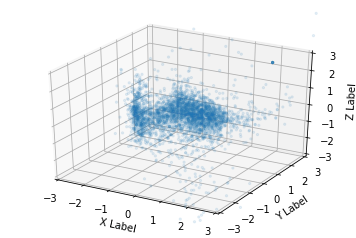

In [340]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = components[:,0]
y = components[:,1]
z = components[:,2]
ax.scatter(x, y, z, marker='.',alpha=0.1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim(-3,3)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
plt.show()

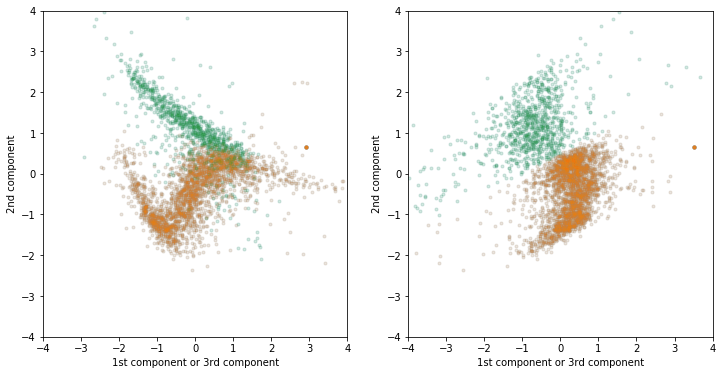

In [373]:
selected_b = (components[:,1] + components[:,0]*4/4 > 0.7) * \
            ~((components[:,2]<1.5)*(components[:,1] - components[:,2]*2/4 < 0.5)*(components[:,2]>-1))
selected_b = ~(components[:,1] - components[:,2]*2/4 < 0.5)

selected_a = (components[:,1] + components[:,0]*3/2 < -2)
selected_a =  ~selected_b

plt.figure(figsize=(12,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(components[:,i*2],components[:,1],'.',alpha=0.1)
    plt.plot(components[:,i*2][selected_a],components[:,1][selected_a],'.',alpha=0.1)
    plt.plot(components[:,i*2][selected_b],components[:,1][selected_b],'.',alpha=0.1)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.xlabel('1st component or 3rd component')
    plt.ylabel('2nd component')
plt.show()

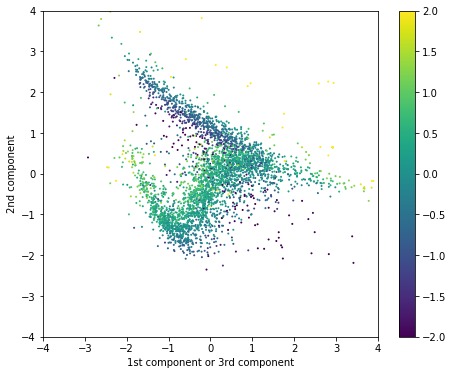

In [349]:
plt.figure(figsize=(7.5,6))
plt.scatter(components[:,0],components[:,1],c=components[:,2],s=1,vmin=-2,vmax=2)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel('1st component or 3rd component')
plt.ylabel('2nd component')
plt.colorbar()
plt.show()

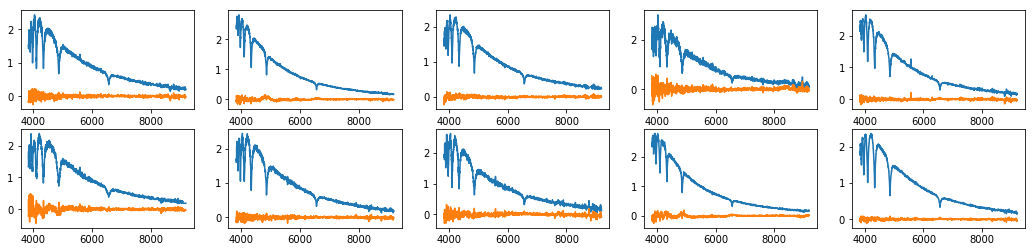

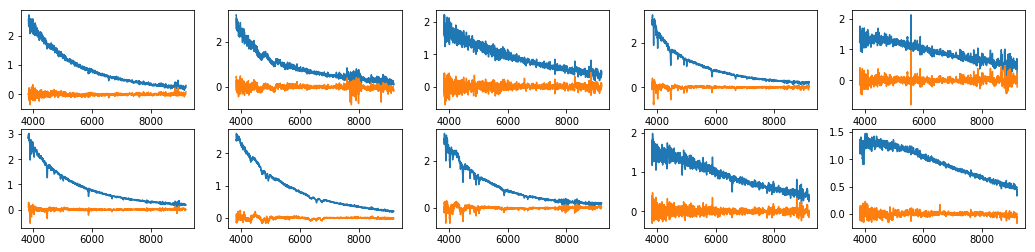

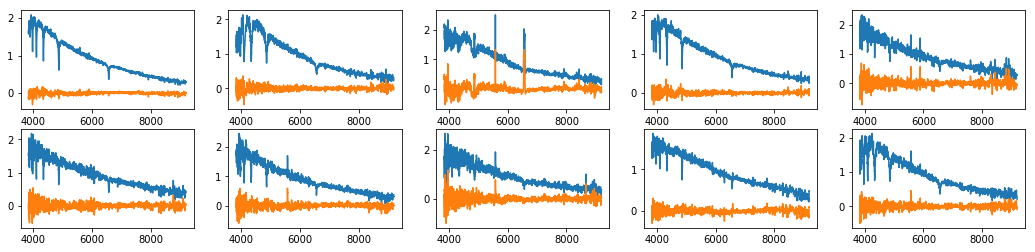

In [359]:
selected = selected_a
for selected in [selected_a,selected_b,selected_c]:
    plt.figure(figsize=(18,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.plot(lam_standard,spec[selected][i,:])
        plt.plot(lam_standard,spec[selected][i,:] - pca.inverse_transform(components[selected][i]))
    plt.show()

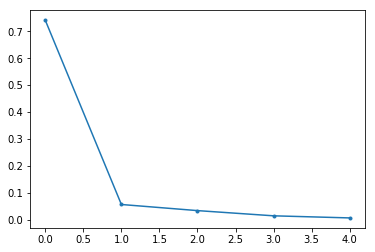

[ 0.74051337  0.05783607  0.03518464  0.01588338  0.00810285]


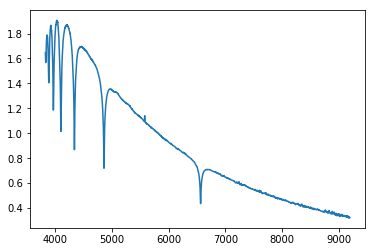

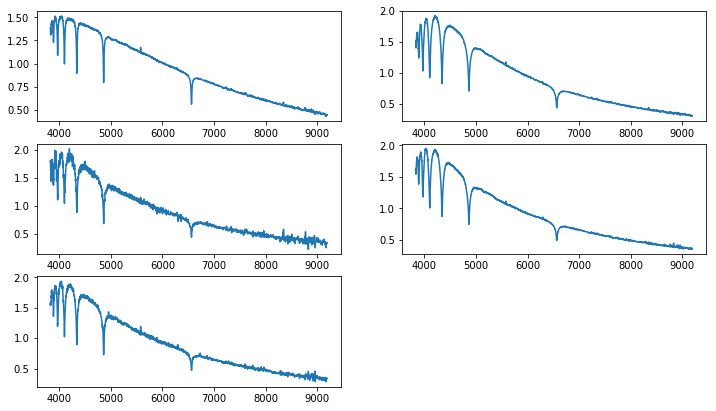

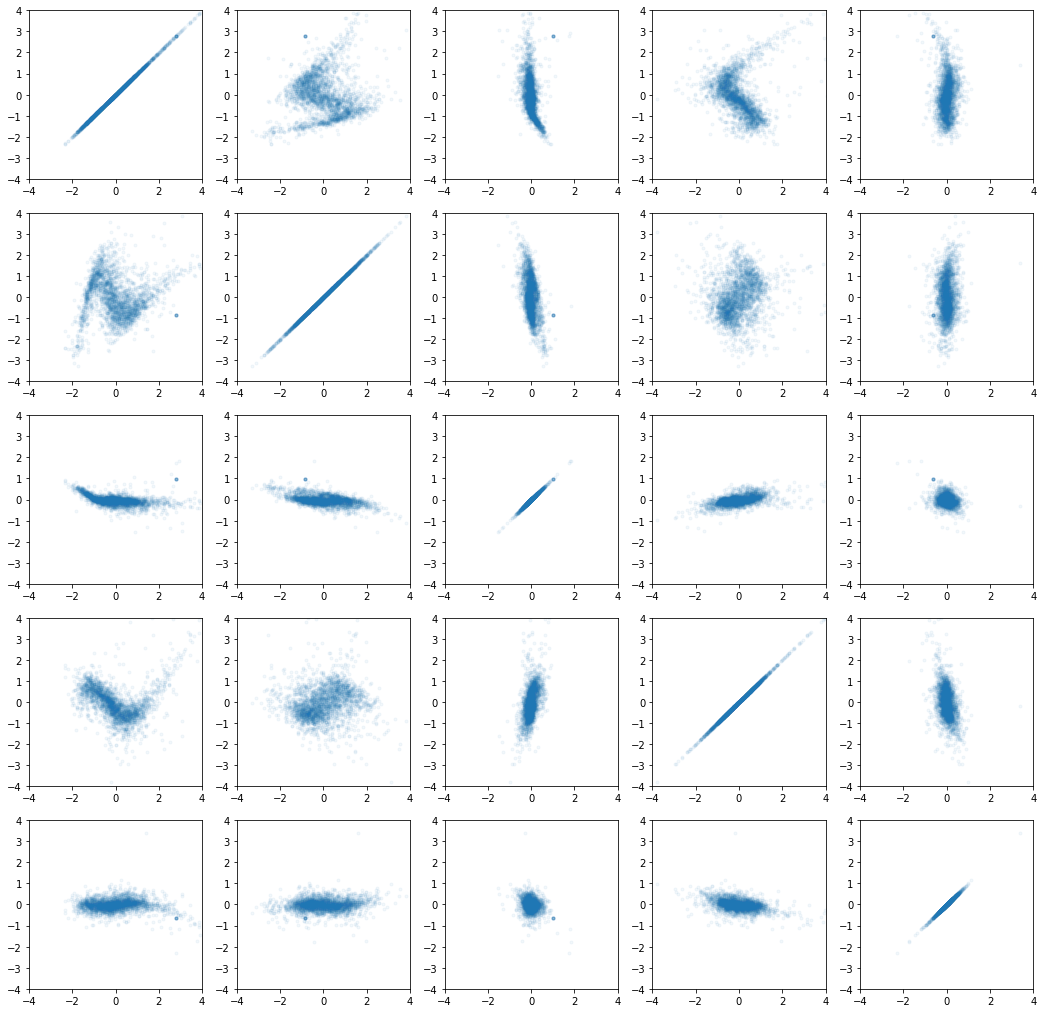

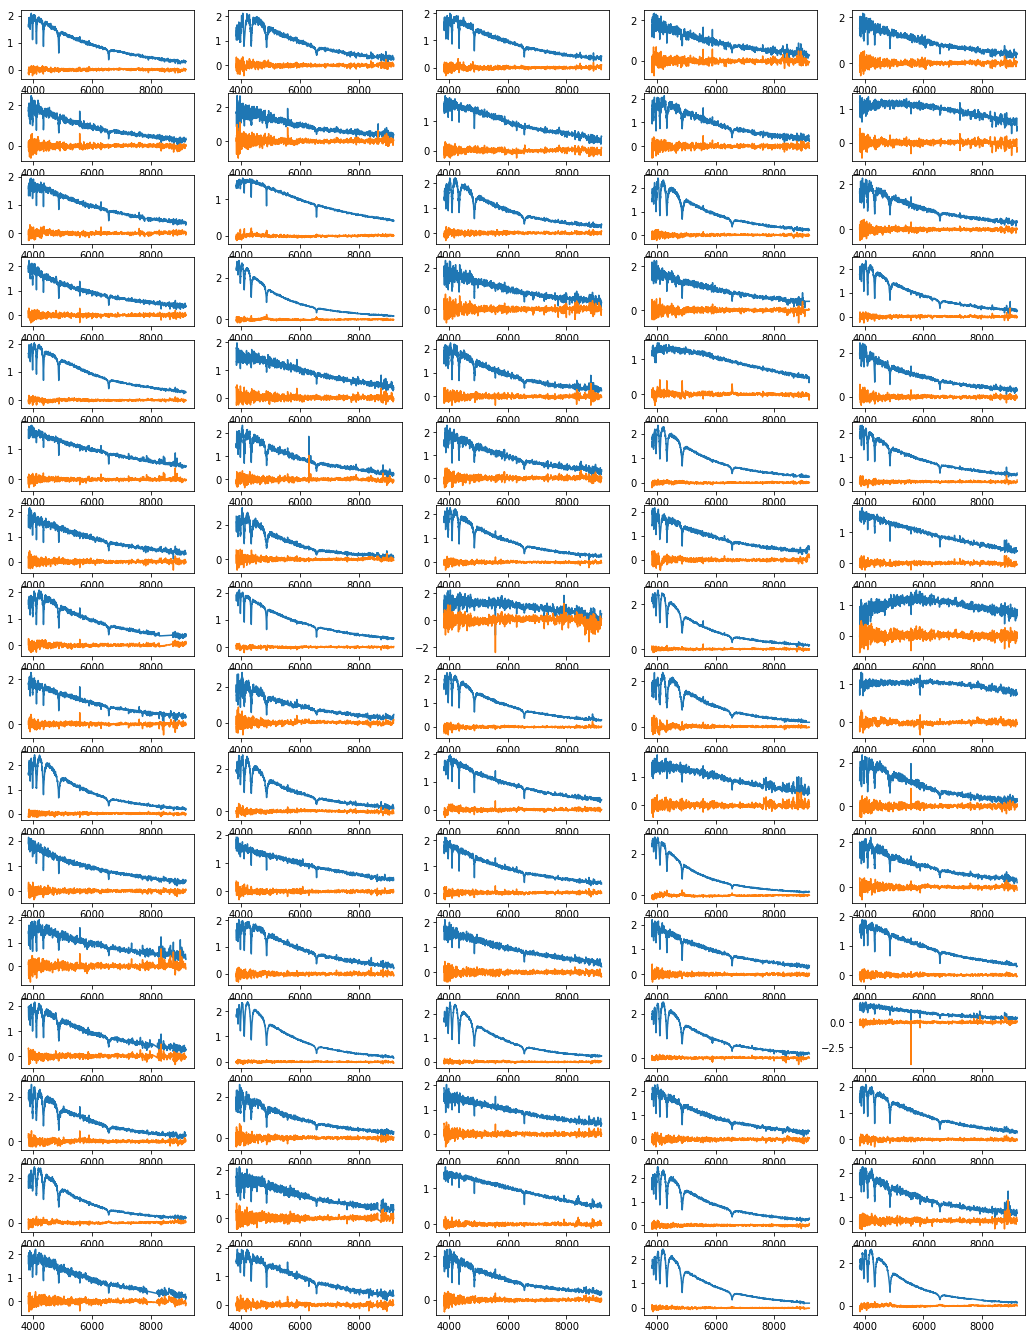

In [417]:
pca_A,_ = pca_analysis(spec[selected_a], lam_standard, 5)

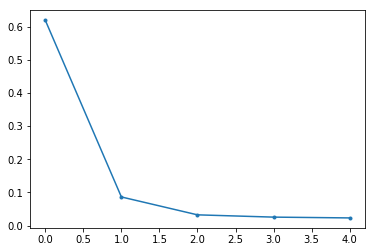

[ 0.61918675  0.08626875  0.03232331  0.02546297  0.02306365]


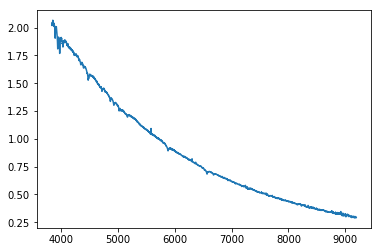

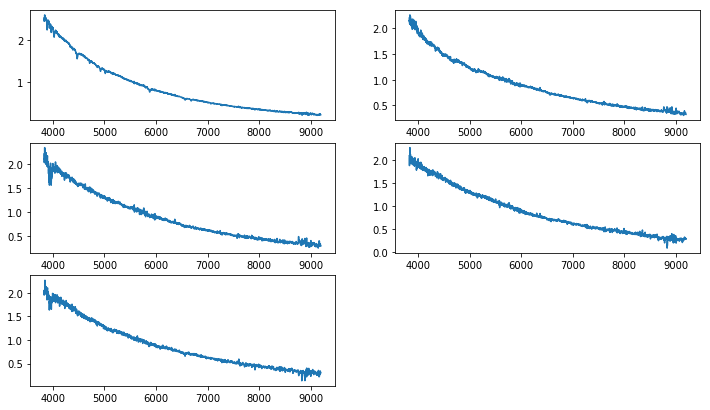

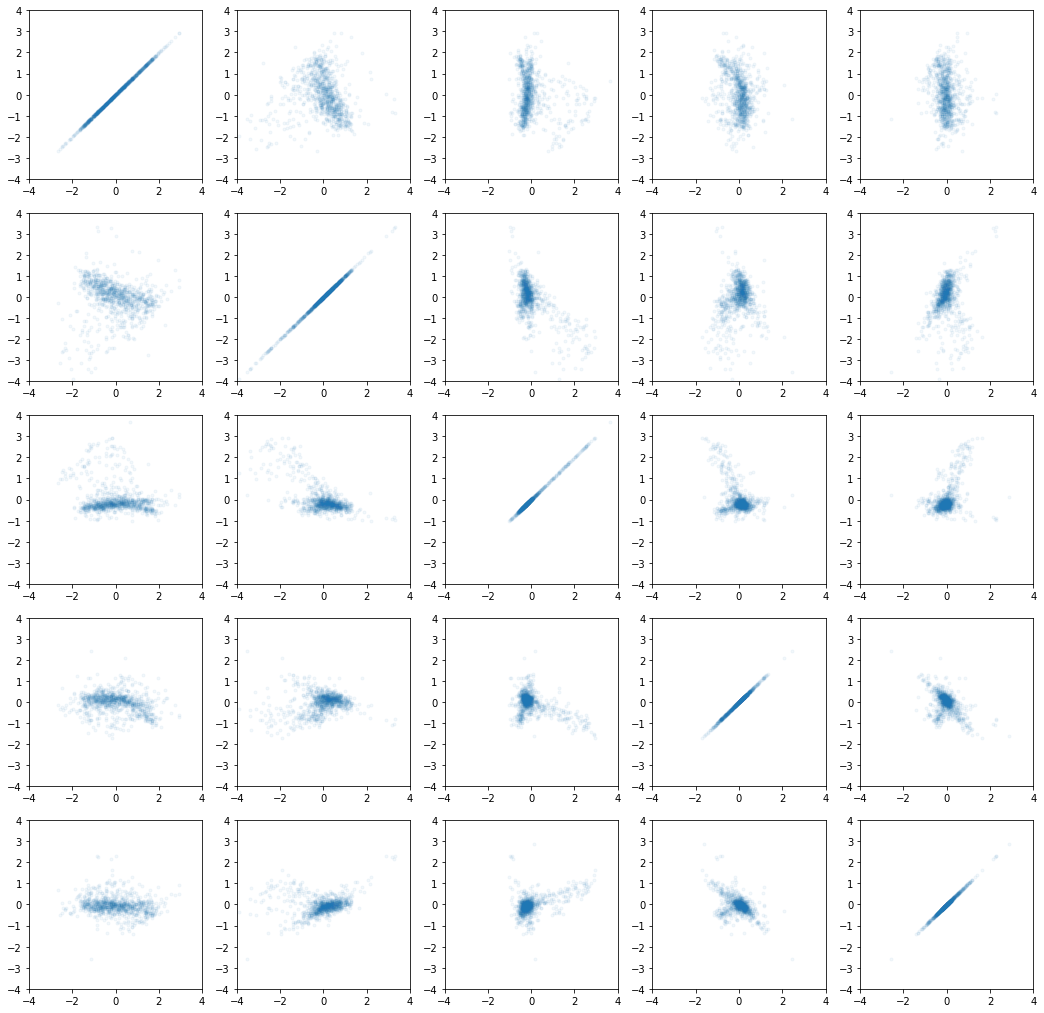

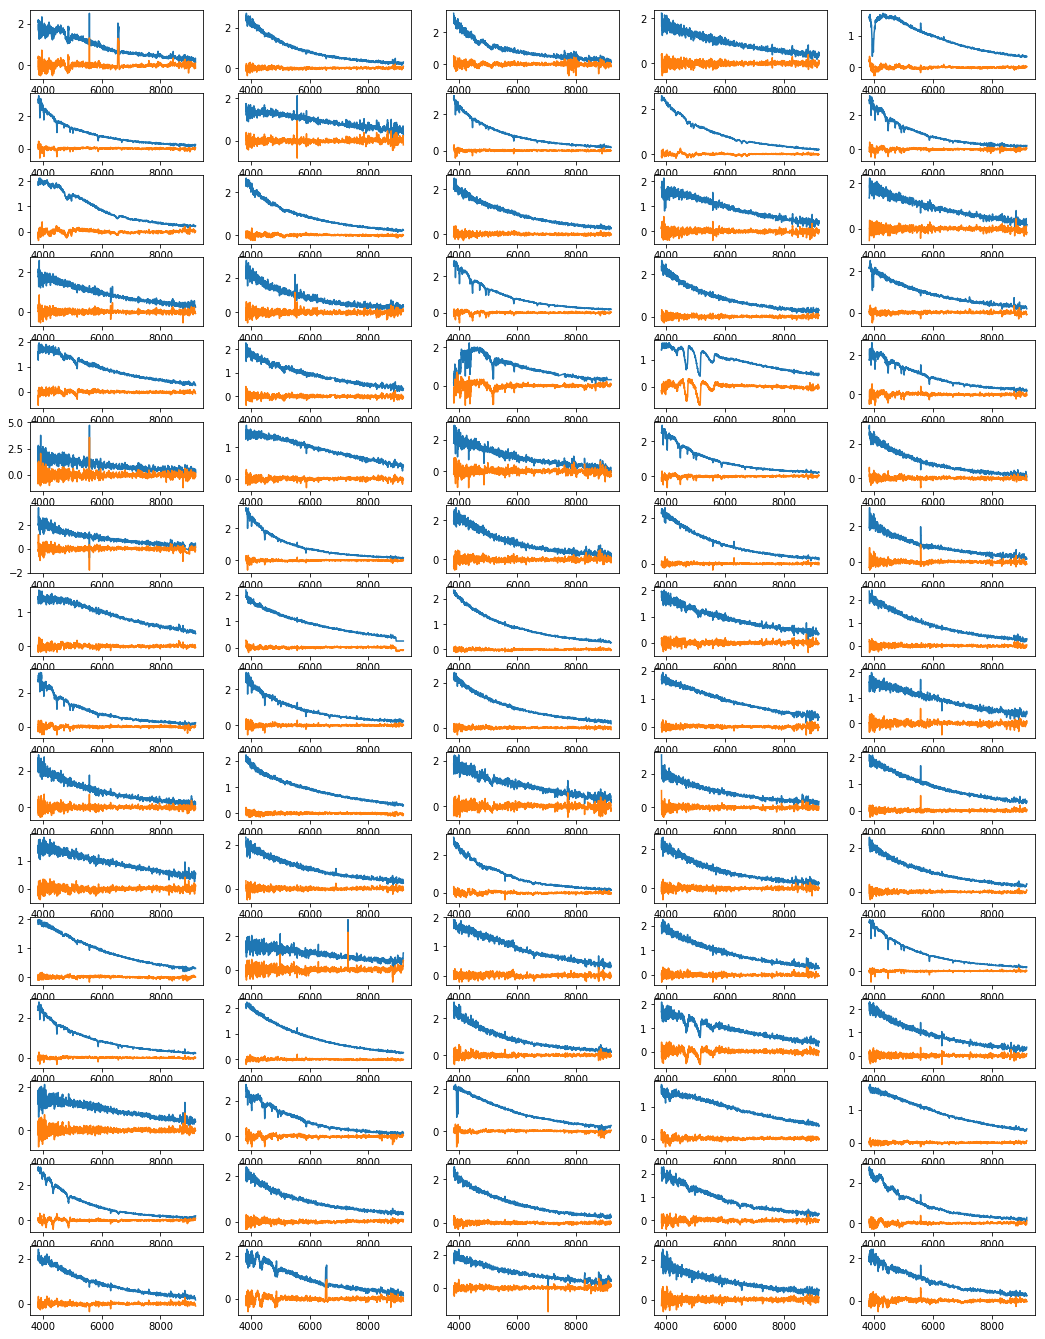

In [418]:
pca_B,_ = pca_analysis(spec[selected_b], lam_standard, 5)

In [549]:
spec[selected_b].shape

(946, 3803)

In [559]:
selected = pca_B.transform(spec[selected_b])[:,2]>0.5
selected = np.where(selected_b)[0][selected]
selected.size

108

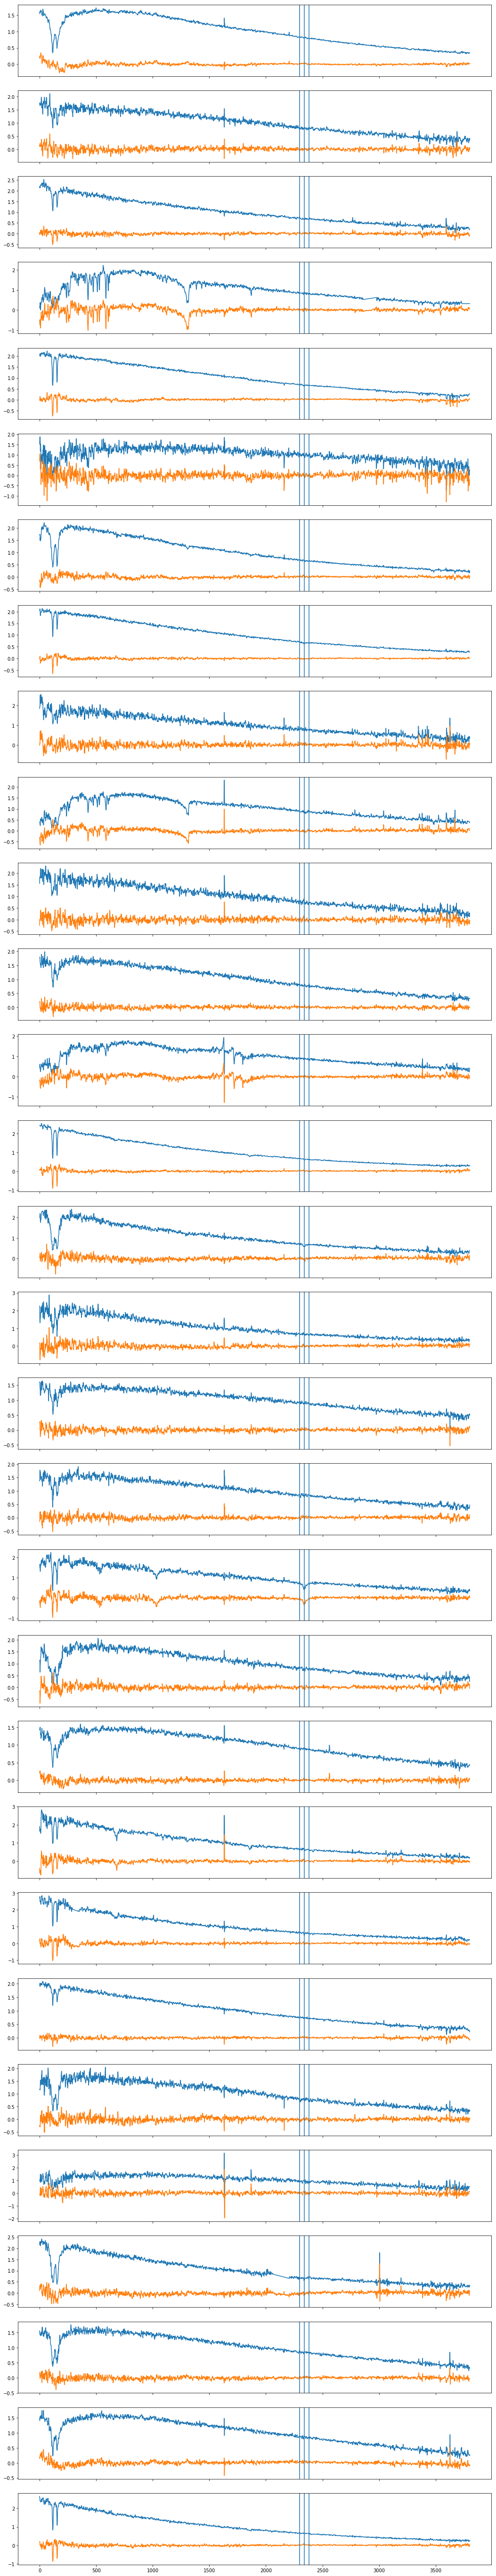

In [562]:
pca = pca_B
n = 30
components = pca.transform(spec[selected,:])
fig, axes = plt.subplots(n,1, sharex='col',figsize=(18,100))
for i in range(n):
    axes[i].plot(spec[selected[i],:])
    axes[i].plot(spec[selected[i],:] - pca.inverse_transform(components[i]))
    axes[i].axvline(2340)
    axes[i].axvline(2380)
    axes[i].axvline(2300)
plt.show()

(array([   3,  112,  160,  197,  243,  254,  353,  484,  572,  574,  600,
        645,  701,  720,  721,  859,  863,  961, 1159, 1335, 1450, 1638,
       2327, 2601, 2887, 2899, 2989]),)


/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


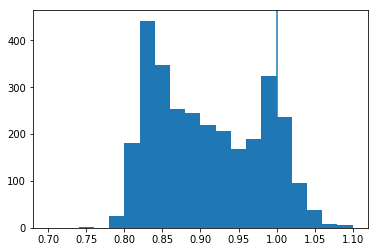

In [636]:
H_alpha = spec[index,2300:2380].sum(axis=1) /80 / (spec[index,2300]+spec[index,2380]) * 2 * 0.4 + \
                    spec[index,985:1085].sum(axis=1)/100 / (spec[index,985]+spec[index,1085]) * 2 * 0.6
#H_alpha = spec[:,2340] / (spec[:,2300]+spec[:,2380]) * 2 * 0.4 + spec[:,1035] / (spec[:,985]+spec[:,1085]) * 2 * 0.6

DB = np.abs(H_alpha-0.99)<0.02
DA = H_alpha<0.80
#print(np.where(DA))
print(np.where(DA))
plt.hist(H_alpha,20,(0.7,1.1))
plt.axvline(1)
plt.show()

In [627]:
H_alpha

array([ 84.89549742,  77.16727517,  91.40308147, ...,  84.0597393 ,
        75.26832672,  89.47278383])

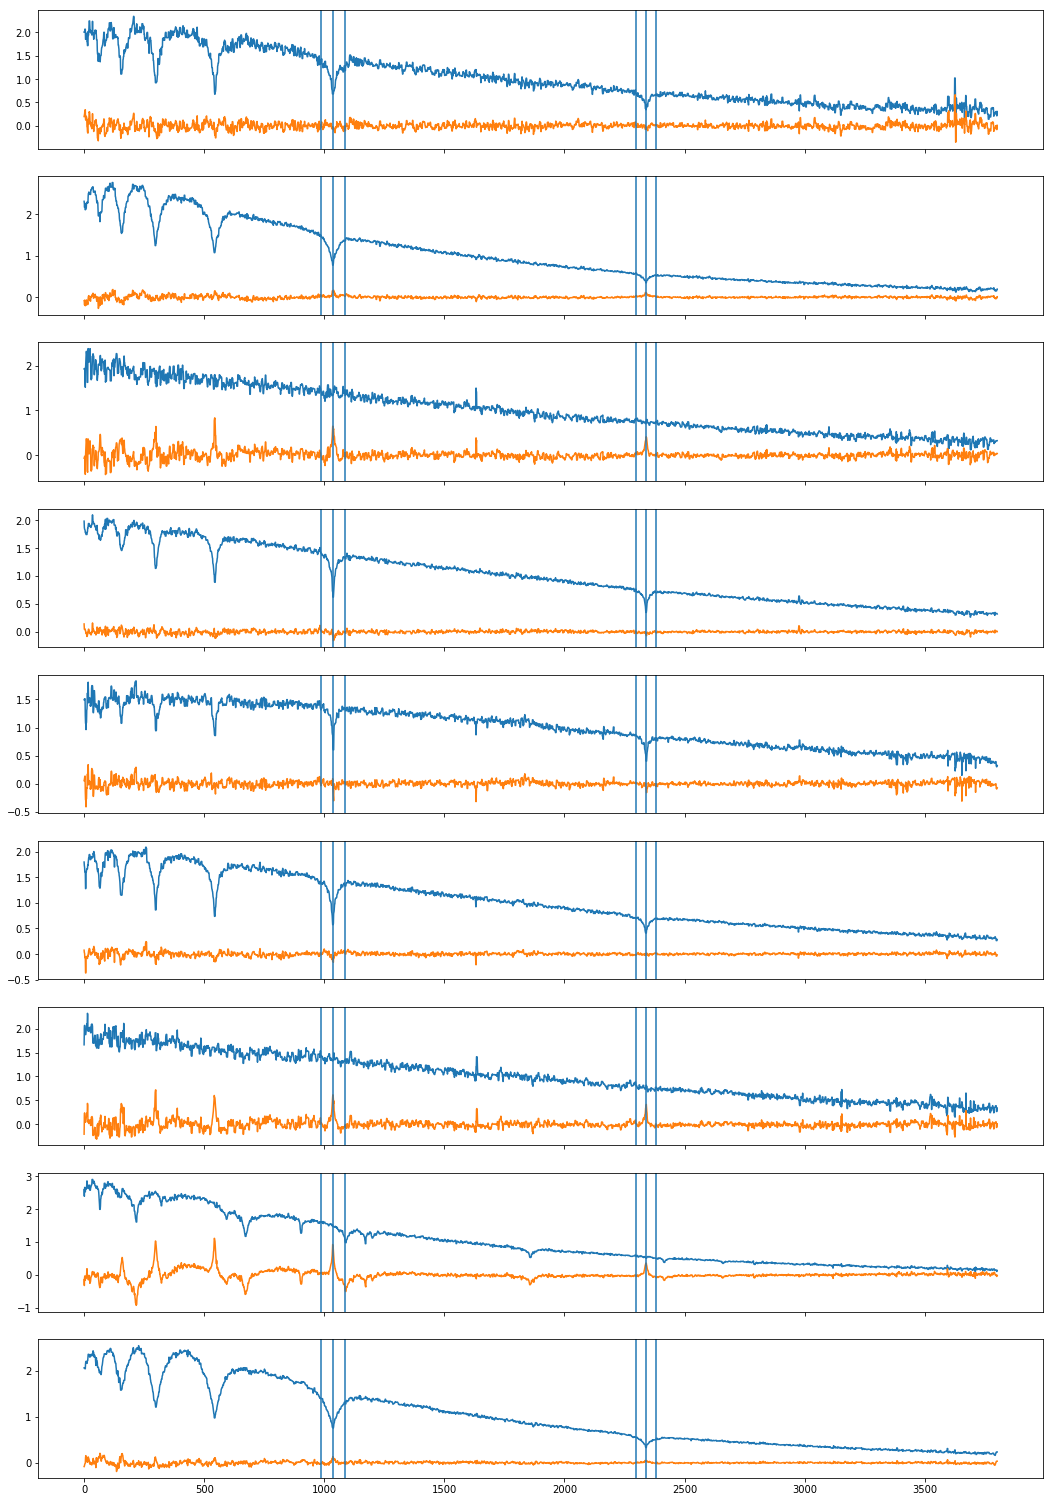

In [567]:
pca = pca_A
components = pca.transform(spec[index,:])
fig, axes = plt.subplots(9,1, sharex='col',figsize=(18,27))
for i in range(9):
    axes[i].plot(spec[index[i],:])
    axes[i].plot(spec[index[i],:] - pca.inverse_transform(components[i]))
    axes[i].axvline(2340)
    axes[i].axvline(2380)
    axes[i].axvline(2300)
    
    axes[i].axvline(1035)
    axes[i].axvline(985)
    axes[i].axvline(1085)
plt.show()

In [585]:
DB

array([False, False,  True, ...,  True,  True, False], dtype=bool)

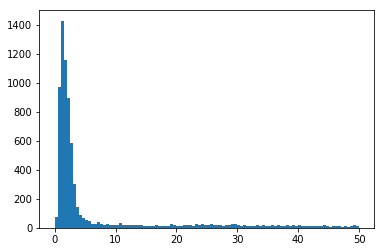

11788.235709 241


In [27]:
selected = (data['koi_steff']<3900)
factor = ((data['koi_period']/365)**(2/3)/data['koi_sma']**(1/3)*231/data['koi_srad'])
(factor[selected]).sum()
plt.hist(data['koi_prad'],range=(0,50),bins=100)
plt.show()
print((factor[selected*(factor<150)*(data['koi_prad']<4)]).sum(),selected.sum())

In [28]:
data = Table.read('cumulative.csv')
len(data)

7931